In [2]:
%autosave 0
%matplotlib inline
import sys, os
sys.path.insert(0, os.path.expanduser('/Users/peadarcoyle/Code/Advanced_PyMC3_Talk/'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions.discrete import BetaBinomial
import seaborn as sns
from theano import config, shared, function
from theano.gradient import jacobian
import theano.tensor as tt

config.floatX = 'float32'

Autosave disabled


In [3]:
from abc import ABCMeta, abstractmethod

class NormalizingFlow:
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def init_model_params(self, d):
        """Initialize model parameters
        
        This method is called in ADVI inference functions, because 
        the dimension of parameter vector is difficult to know before 
        inference. 
        
        d : int
            Dimension of parameter vector.
        """
        pass
    
    @abstractmethod
    def trans(self, z_pre):
        """Transform variable (vector). """
        pass
    
    @abstractmethod
    def ldj(self, z_pre):
        """Returns logdet of Jacobian. """
        pass
    
    @abstractmethod
    def get_params(self):
        """Returns parameters. """
        pass

## Normalizing flows
In a previous notebook I mentioned normalizing flows. 
This is a method used to get over one of the objections to Variational Inference. 

* This work is beta - and is a reviewed and extended version of the work of Taku Yoshioka one of the core-contributors to PyMC3 who's done a lot of the ADVI stuff. 

In [4]:
class SimpleMadeIAF(NormalizingFlow):
    """An inverse autoregressive flow: (z - f1(z, h1, g1)) / f2(z, h2, g2)
    
    f[1/2] are MADEs, whose connectivity constraints are deterministically set. 
    h[1/2] are the activation functions of the hidden layers in f[1/2]. 
    g[1/2] are the activation functions of the output layers in f[1/2]. 
    The number of units in all layers are same with the dimension of the 
    random variable in ADVI. 
    
    Parameters
    ----------
    ns : list of int
        The numbers of units in all layers, shared for f1 and f2.
    hs : (tensor -> tensor, tensor -> tensor)
        Elementwise activation function of the hidden layers in f[1/2].
    gs : (tensor -> tensor, tensor -> tensor)
        Elementwise activation function of the output layer in f[1/2].
    rev_order : bool
        If true, the order of connectivity constraints is reversed.
    random_seed : int or None
        Random seed for initialization of weight matrices.

    Example
    -------
    ls = (1, 1)
    hs = (tt.nnet.sigmoid, tt.nnet.sigmoid)
    gs = ((lambda x: x), tt.nnet.softplus)
    SimpleMadeIAF(ls, hs, gs, 'upper')
    """
    def __init__(self, ns, hs, gs, rev_order=False, random_seed=None):
        self.ns = ns
        self.hs = hs
        self.gs = gs
        self.model_params = None
        self.rev_order = rev_order
        self.rng = np.random.RandomState(random_seed)
    
    def init_model_params(self, d):
        self.d = d
        w1s, b1s = _init_made_params([d] + self.ns + [d], self.rng) # f1
        w2s, b2s = _init_made_params([d] + self.ns + [d], self.rng) # f2
        self.wss = (w1s, w2s)
        self.bss = (b1s, b2s)
        self.model_params = w1s + w2s + b1s + b2s

        # Masks
        self.mask1s = _create_made_masks(self.d, self.ns, self.rev_order)
        self.mask2s = _create_made_masks(self.d, self.ns, self.rev_order)
        
    def trans(self, zs):
        """Transform random variables and compute log determinant of Jacobian.
        
        Parameters
        ----------
        zs : tensor, shape=(n_mc_samples, dim_rv)
            Random variables. n_mc_samples denotes the number of Monte Carlo samples
            in ADVI. dim_rv is the dimension of (concatenated) random variables. 
            
        Returns
        -------
        (zs_new, ldjs) : (tensor, tensor)
            Transformed random variables and log determinant of Jacobians.
            zs_new.shape is the same with zs. ldjs.shape = (n_mc_samples,). 
        """
        # Outputs of MADEs
        n_layers = len(self.ns)
        h1, h2 = self.hs
        g1, g2 = self.gs
        w1s, w2s = self.wss
        b1s, b2s = self.bss
        
        def f(zs, n_layers, h, g, ws, bs, masks):
            """MADE"""
            xs = zs
            for l in range(n_layers):
                xs = h(xs.dot(masks[l] * ws[l]) + bs[l])
            return g(xs.dot(masks[n_layers] * ws[n_layers]) + bs[n_layers])
        
        f1s = f(zs, n_layers, h1, g1, w1s, b1s, self.mask1s)
        f2s = f(zs, n_layers, h2, g2, w2s, b2s, self.mask2s)
        
        # Outputs
        zs_new = (zs - f1s) / f2s
        
        # Log determinant of Jacobian
        ldjs = -tt.sum(tt.log(f2s), axis=-1)
        
        return zs_new, ldjs
        
    def get_params(self):
        if self.model_params is None:
            raise RuntimeError("get_params() was invoked before trans().")
        else:
            return self.model_params

In [5]:
def _init_made_params(ns, rng):
    """Initialize model parameters of a MADE.
    
    Parameters
    ----------
    l : int
        The numbers of units in all layers, 
        including the input and output layers.
    rng : numpy.random.RandomState
        Random number generator.
    
    Returns
    -------
    (ws, bs) : (List[shared], List[shared])
        Model parameters (weights and biases).
    """
    ws = list()
    bs = list()
    for l in range(len(ns) - 1):
        d_in = ns[l]
        d_out = ns[l + 1]
        ws.append(shared(0.01 * rng.randn(d_in, d_out).astype('float32')))
        bs.append(shared(0.01 * rng.randn(d_out).astype('float32')))

    return ws, bs


def _create_made_mask(d_pre, d, m_pre, output_layer, rev_order=False):
    """Create a mask for MADE.
    
    Parameters
    ----------
    d_pre : int
        The number of rows in the weight matrix. 
    d : int
        The number of columns in the weight matrix. 
    m_pre : numpy.ndarray, shape=(d_pre,)
        The number of inputs to the units in the previous layer.
    output_layer : bool
        True for the output layer. 
    rev_order : bool
        If true, the order of connectivity constraints is reversed. 
        It is used only for the output layer. 
    
    Returns
    -------
    m, mask : (numpy.ndarray, numpy.ndarray)
        Mask indices and Mask.
    """
    d_input = np.max(m_pre)
    mask = np.zeros((d_pre, d)).astype('float32')
    
    if not output_layer:
        m = np.arange(1, d_input).astype(int)
        if len(m) < d:
            m = np.hstack((m, (d_input - 1) * np.ones(d - len(m))))
            
        for ix_col in range(d):
            ixs_row = np.where(m_pre <= m[ix_col])[0]
            (mask[:, ix_col])[ixs_row] = 1

    else:
        m = np.arange(1, d + 1)
        if rev_order:
            m = m[::-1]
        for ix_col in range(d):
            ixs_row = np.where(m_pre < m[ix_col])[0]
            mask[ixs_row, ix_col] = 1
            
    return m, mask


def _create_made_masks(d, ns, rev_order=False):
    """Create masks for all layers.
    
    Parameters
    ----------
    d : int
        Input dimension.
    ns : list of int
        The numbers of units in all hidden layers. 
    rev_order : bool
        If true, the order of connectivity constraints is reversed.
        
    Returns
    -------
    masks : List[numpy.ndarray]
        List of masks.
    """
    # The number of layers
    n_layers = len(ns)
    
    # Mask indices for the input layer
    m = np.arange(1, d + 1).astype(int)
    if rev_order:
        m = m[::-1]
    masks = list()
    
    d_pre = d
    for l, n in zip(range(n_layers), ns):
        m, mask = _create_made_mask(d_pre, n, m, output_layer=False)
        masks.append(mask)
        d_pre = n
    _, mask = _create_made_mask(d_pre, d, m, output_layer=True, 
                                rev_order=rev_order)

    masks.append(mask)
    
    return masks

# Stochastic Volatility model

In [6]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy.sparse import csc_matrix
from scipy import optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(\frac{y_i}{y_{i-1}}) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [7]:
n = 400
returns = np.genfromtxt("./SP500.csv")[-n:]
returns[:5]

array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])

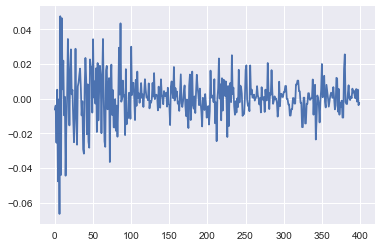

In [8]:
plt.plot(returns)

Specifying the model in pymc3 mirrors its statistical specification. 

In [9]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    nu = pm.Exponential('nu', 1./10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm.StudentT('r', nu, lam=tt.exp(-2*s), observed=returns)

Applied log-transform to sigma and added transformed sigma_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. However, if we fix `log_sigma` and `nu` it is no longer degenerate, so we find the MAP with respect to the volatility process, 's', keeping `log_sigma` and `nu` constant at their default values. 

We use L-BFGS because it is more efficient for high dimensional functions (`s` has n elements).

In [10]:
import lasagne
from collections import OrderedDict

adam = lambda loss, param: lasagne.updates.adam(loss, [param], learning_rate=0.001)

n_unitss = [500]
hs = (tt.nnet.sigmoid, tt.nnet.sigmoid)
gs = (tt.nnet.softplus, tt.exp)
iaf1 = SimpleMadeIAF(n_unitss, hs, gs, rev_order=False, random_seed=0)
iaf2 = SimpleMadeIAF(n_unitss, hs, gs, rev_order=True, random_seed=1)
nfs = [iaf1, iaf2]

with model:
    mu, sds, elbo = pm.variational.advi_minibatch(
        n=100000, optimizer=adam, minibatch_tensors=[], minibatches=[], 
        observed_RVs=OrderedDict({r: 1}), local_RVs=OrderedDict(), 
        global_NFs=nfs)

Iteration 0 [0%]: ELBO = -524080.74
Iteration 10000 [10%]: Average ELBO = 813.17
Iteration 20000 [20%]: Average ELBO = 1136.14
Iteration 30000 [30%]: Average ELBO = 1162.57
Iteration 40000 [40%]: Average ELBO = 1182.15
Iteration 50000 [50%]: Average ELBO = 1194.56
Iteration 60000 [60%]: Average ELBO = 1202.17
Iteration 70000 [70%]: Average ELBO = 1206.88
Iteration 80000 [80%]: Average ELBO = 1209.8
Iteration 90000 [90%]: Average ELBO = 1212.27
Finished [100%]: ELBO = 1211.28


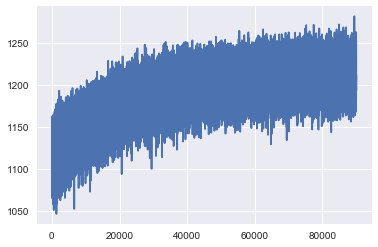

In [11]:
plt.plot(elbo[10000:])

We do a short initial run to get near the right area, then start again using a new Hessian at the new starting point to get faster sampling due to better scaling. We do a short run since this is an interactive example.

In [12]:
with model:
    # Start next run at the last sampled position.
    step = pm.NUTS(scaling=model.dict_to_array(sds)**2, is_cov=True)
    trace = pm.sample(2000, step, start=mu)

100%|██████████| 2000/2000 [02:50<00:00, 13.06it/s]


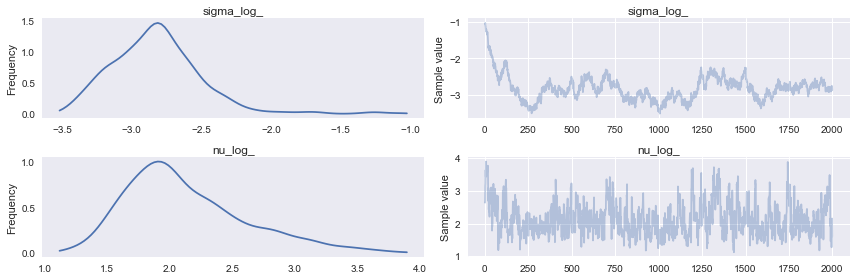

In [13]:
figsize(12,6)
pm.traceplot(trace, model.vars[:-1]);

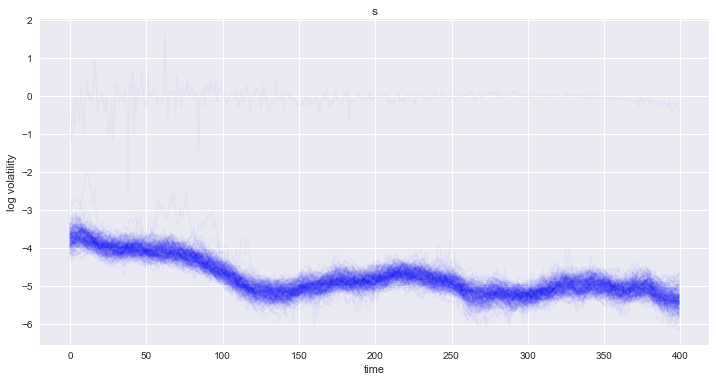

In [14]:
figsize(12,6)
title(str(s))
plot(trace[s][::10].T,'b', alpha=.03);
xlabel('time')
ylabel('log volatility')

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

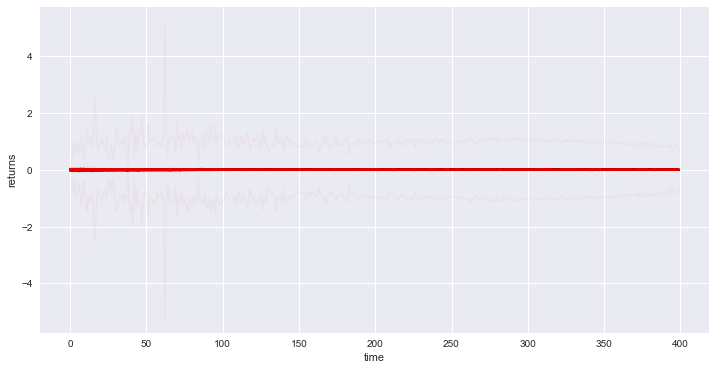

In [15]:
plot(returns)
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
plot(-np.exp(trace[s][::10].T), 'r', alpha=.03);
xlabel('time')
ylabel('returns')

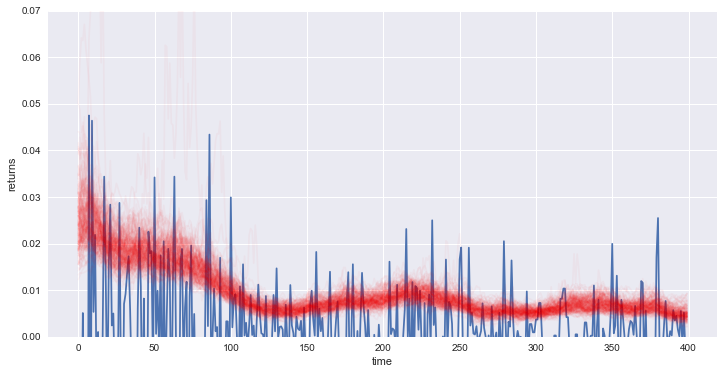

In [16]:
plot(returns)
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
plot(-np.exp(trace[s][::10].T), 'r', alpha=.03);
xlabel('time')
ylabel('returns')
plt.ylim(0.00, 0.07);

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 